In [1]:
import gtdynamics as gtd
from gtdynamics import ContactGoal, PointOnLink, Slice, Interval
from gtsam import Pose3, Point3
import numpy as np
import pandas
import plotly.express as px
import pybullet as p
import gtsam
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d # run: python3 -m pip install --upgrade matplotlib
# import roboplot  # Be sure to install package with `pip install -U roboplot`
import unittest
import networkx as nx
import find_holds

In [2]:
# Bring in the robot model
# robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf");
robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/quad_climb_robot.urdf"); # robot object
# roboplot.plot_robot(robot, "body")

In [3]:
link_names = [(link.id(), link.name()) for link in robot.links()]
link_names.sort()
print(link_names)

[(0, 'body'), (1, 'hip2'), (2, 'upper2'), (3, 'lower2'), (4, 'grab2'), (5, 'hip3'), (6, 'upper3'), (7, 'lower3'), (8, 'grab3'), (9, 'hip0'), (10, 'upper0'), (11, 'lower0'), (12, 'grab0'), (13, 'hip1'), (14, 'upper1'), (15, 'lower1'), (16, 'grab1')]


In [11]:
joint_names = [(joint.id(), joint.name(), joint) for joint in robot.joints()]
print(joint_names)

[(9, '0', 0
	id=9
	parent link: hip0
	child link: upper0
	screw axis (parent):  2.65359e-06            1 -1.27535e-22            0            0            0), (10, '1', 1
	id=10
	parent link: upper0
	child link: lower0
	screw axis (parent): -4.91555e-17           -1  -5.4733e-17 -4.33873e-17 -7.11529e-18         0.13), (0, '10', 10
	id=0
	parent link: body
	child link: hip2
	screw axis (parent):   -0    0   -1 0.15 0.15   -0), (4, '11', 11
	id=4
	parent link: body
	child link: hip3
	screw axis (parent):     0    -0    -1  0.15 -0.15     0), (11, '12', 12
	id=11
	parent link: lower0
	child link: grab0
	screw axis (parent):           -1  1.45921e-16   7.0666e-16 -2.33392e-32 -2.77556e-16  2.42861e-17), (15, '13', 13
	id=15
	parent link: lower1
	child link: grab1
	screw axis (parent):           -1  -4.1587e-17  1.72881e-16   1.3105e-32 -5.55112e-17    6.245e-17), (3, '14', 14
	id=3
	parent link: lower2
	child link: grab2
	screw axis (parent):           -1 -1.15834e-16  6.77853e-16  1.9766

In [4]:
# # Figure out which feet are front, back:
# for name in ["r_wrist","l_wrist","l_ankle","r_ankle"]:
#     print(name, robot.link(name).wTcom().translation())
# print(dir(robot.link("r_gripper")))
# print(robot.link("r_gripper").lTcom())

for name in ["grab0","grab1","grab2","grab3"]:
    print(name, robot.link(name).bMcom().translation())
# relative to link that is above it

grab0 [ 0.44521309  0.40246222 -0.02307521]
grab1 [-0.44521242  0.402463   -0.02307521]
grab2 [ 0.44521175 -0.40246379 -0.02307521]
grab3 [-0.44521242 -0.402463   -0.02307521]


In [5]:
# Joints for each contact
r_hand = "grab0" # leg 1 = red
r_wrist = "12"
r_elbow = "1"
r_shoulder_h = "8"
r_shoulder_v = "0"

l_hand = "grab1" # leg 2 = purple
l_wrist = "13"
l_elbow = "3"
l_shoulder_h = "9"
l_shoulder_v = "2"

r_foot = "grab2" # leg 3 = green
r_ankle = "14"
r_knee = "5"
r_hip_h = "10"
r_hip_v = "4"

l_foot = "grab3" # leg 4 = blue
l_ankle = "15"
l_knee = "7"
l_hip_h = "11"
l_hip_v = "6"

contact_in_com = [0, 0, 0]  # place on link, relative to link, that will be the contact point
LH = PointOnLink(robot.link(l_hand), contact_in_com)
LF = PointOnLink(robot.link(l_foot), contact_in_com)
RH = PointOnLink(robot.link(r_hand), contact_in_com)
RF = PointOnLink(robot.link(r_foot), contact_in_com)

# # Test trivial inverse kinematics 
contact_goals = [
    ContactGoal(LH, robot.link(l_hand).bMcom().translation()),
    ContactGoal(LF, robot.link(l_foot).bMcom().translation()),
    ContactGoal(RH, robot.link(r_hand).bMcom().translation()),
    ContactGoal(RF, robot.link(r_foot).bMcom().translation()),
    ]
print(contact_goals)

# mapping = {
#     "LH":robot.link("grab1"),
#     "LF":robot.link("grab3"),
#     "RF":robot.link("grab2"),
#     "RH":robot.link("grab0"),
#     }
# print([(key,link.id()) for key,link in mapping.items()])

[{{grab1, [0 0 0]}, [ -0.445212   0.402463 -0.0230752]}, {{grab3, [0 0 0]}, [ -0.445212  -0.402463 -0.0230752]}, {{grab0, [0 0 0]}, [  0.445213   0.402462 -0.0230752]}, {{grab2, [0 0 0]}, [  0.445212  -0.402464 -0.0230752]}]


In [6]:
kinematics = gtd.Kinematics()
result = kinematics.inverse(Slice(4), robot, contact_goals)
# print(result)

# Example of getting Pose and JointAngle after IK
r_hand_trans = robot.link(r_hand).bMcom().translation()
r_foot_trans = robot.link(r_foot).bMcom().translation()
l_hand_trans = robot.link(l_hand).bMcom().translation()
l_foot_trans = robot.link(l_foot).bMcom().translation()
print(r_hand_trans, r_foot_trans, l_hand_trans, l_foot_trans)
pose_after_ik = gtd.Pose(result, robot.link(r_hand).id(), 4) # 4 for slice(4)
print(pose_after_ik)
# jointAngle_after_ik = gtd.JointAngleDouble(result, robot.joint(r_wrist).id(), 4) # 4 for slice(4)
# print(pose_after_ik)
# print(jointAngle_after_ik)

[ 0.44521309  0.40246222 -0.02307521] [ 0.44521175 -0.40246379 -0.02307521] [-0.44521242  0.402463   -0.02307521] [-0.44521242 -0.402463   -0.02307521]
R: [
	-0.535089, 0.618742, 0.575186;
	-0.44688, -0.785111, 0.428836;
	0.716923, -0.0275736, 0.696607
]
t:   0.445242   0.402454 -0.0231034



In [13]:
# Example of checking if goal is satisfied
for goal in contact_goals:
    print(goal.link().name(), goal.satisfied(result,k=4,tol=1e-3))

grab1 True
grab3 True
grab0 True
grab2 True


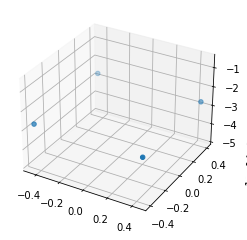

In [14]:
# Plot current location of robot in 3D
points = np.asarray([robot.link(l_hand).bMcom().translation(), 
                     robot.link(l_foot).bMcom().translation(), 
                     robot.link(r_hand).bMcom().translation(), 
                     robot.link(r_foot).bMcom().translation()])


%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')


ax.scatter3D(points[:, 0], points[:, 1], points[:, 2]);

In [15]:
class TestRobot(unittest.TestCase):
    
    def testInverseKinematicsHands(self):
        # robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf")
        robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/quad_climb_robot.urdf"); # robot object
        contact_goals = [
            ContactGoal(LH, robot.link(l_hand).bMcom().translation()),
            ContactGoal(LF, robot.link(l_foot).bMcom().translation()),
            ContactGoal(RH, robot.link(r_hand).bMcom().translation()),
            ContactGoal(RF, robot.link(r_foot).bMcom().translation()),
        ]
        kinematics = gtd.Kinematics()
        result = kinematics.inverse(Slice(4), robot, contact_goals)
        for goal in contact_goals:
            self.assertTrue(goal.satisfied(result,k=4,tol=1e-3))
            
    def testInverseKinematicsAll(self):
        # robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/humanoid/nao.urdf")
        robot = gtd.CreateRobotFromFile(gtd.URDF_PATH + "/quad_climb_robot.urdf"); # robot object
        contact_goals = [
            ContactGoal(LH, robot.link(l_hand).bMcom().translation()),
            ContactGoal(LF, robot.link(l_foot).bMcom().translation()),
            ContactGoal(RH, robot.link(r_hand).bMcom().translation()),
            ContactGoal(RF, robot.link(r_foot).bMcom().translation()),
        ]
        kinematics = gtd.Kinematics()
        result = kinematics.inverse(Slice(4), robot, contact_goals)
        for goal in contact_goals:
            self.assertTrue(goal.satisfied(result,k=4,tol=1e-3))
            
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.392s

OK


In [16]:
# This code is broken and I don't know what it was originally for

# _link_name_to_index = {p.getBodyInfo(robot)[0].decode('UTF-8'):-1,}
        
# for _id in range(p.getNumJoints(climb_robot)):
#     _name = p.getJointInfo(pybullet_robot, _id)[12].decode('UTF-8')
#     _link_name_to_index[_name] = _id
# print(_link_name_to_index)

In [17]:
# Start doing the graph search

In [18]:
# Create the graph of the rockwall that the robot will climb
from mpl_toolkits.mplot3d.axes3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

def points_from_image():

    points = [[513, 32, 0.0], [575, 92, 0.0], [535, 119, 0.0], [511, 72, 0.0], [500, 105, 0.0],
              [485, 74, 0.0], [486, 49, 0.0], [446, 88, 0.0], [421, 59, 0.0], [425, 113, 0.0], [416, 105, 0.0],
              [457, 144, 0.5], [511, 173, 1.1], [447, 173, 1.1], [379, 81, -0.4], [319, 81, -0.4], [339, 92, -0.8],
              [319, 111, -0.9], [295, 103, -0.1], [281, 94, 0.1], [282, 123, 1.0],
              [376, 123, -0.1], [321, 129, 0.0], [300, 150, 1.0], [318, 164, 1.9], [348, 159, 1.4], [375, 179, 1.8],
              [386, 145, 1.0], [353, 227, 2.0], [311, 270, 2.0], [256, 224, 2.0], [230, 263, 2.0],
              [425, 203, 1.6], [489, 229, 1.1], [427, 271, 1.5], [369, 286, 1.8], [431, 325, 1.4],
              [525,207, 0.8], [541, 237, 0.9], [596, 193, 0.4], [600, 264, 0.75],
              [564, 293, 1.0], [510, 242, 1.0], [498, 276, 1.0],
              [594, 326, 0.8], [426, 355, 1.3], [388, 347, 1.6], [376, 371, 1.0],
              [489, 371, 0.5], [469, 360, 0.8],
              [326, 326, 1.9], [316, 367, 1.4], [303, 335, 1.7], [283, 364, 1.3], [251, 323, 1.5], [257, 293, 2.0],
              [205, 279, 1.8], [231, 341, 1.5], [198, 316, 1.6], [207, 387, 1.2],
              [265, 155, 1.9], [252, 136, 1.6], [254, 109, 1.3], [242, 92, 0.4], [228, 135, 0.75],
              [208, 123, 0.4], [186, 108, 0.8], [180, 145, 0.2], [149, 128, 0.6], [141, 160, 0.8], [228, 168, 1.0],
              [229, 191, 1.9], [189, 229, 1.9], [195, 178, 0.5], [166, 261, 1.9], [170, 353, 0.0], [139, 312, 0.5],
              [120, 356, 0.4], [73, 341, 1.0], [76, 382, 1.0], [33, 405, 0.4], [65, 299, 1.0], [39, 284, 1.0],
              [156, 165, 0.5], [147, 224, 1.5], [127, 201, 1.0], [122, 127, 1.0], [120, 161, 1.1], [101, 184, 1.3],
              [109, 236, 1.2], [111, 277, 1.0], [80, 275, 1.1], [74, 228, 1.5], [87, 133, 1.4], [61, 154, 1.75],
              [37, 142, 1.5], [43, 211, 1.6], [25, 187, 1.0], [10, 188, 0.0], [22, 285, 0.75], [13, 309, 0.5],
              [14, 244, 0.5], [20, 360, 0.5], [29, 324, 0.8]]

    points = np.array(points)

    # scale for 4ft long arms
    points[:, 0] = points[:, 0] / (616/30)  # 616 -> 30
    points[:, 1] = points[:, 1] / (423/10)  # 423 - > 10
    points[:, 2] = points[:, 2]  # 3 (-1 - 2ft )

    # flip x axis so that it goes 0 to 30, down to up
    points[:, 0] = np.max(points[:, 0]) - points[:, 0]

    return points


def get_random_points(num_points):

    # robots arms are 2ft long - 1ft per link

    points = []
    for pt in range(num_points):

        # climbing wall = 10ft X 30ft, at most 1.5 ft change in z axis
        rand_x = random.randrange(0, 100)
        rand_y = random.randrange(0, 300)
        rand_z = random.randrange(0, 10)

        # randrange needed intergers, but divide to get better data

        rand_x = rand_x / 10
        rand_y = rand_y / 10
        rand_z = rand_z / 10

        points.append([rand_x, rand_y, rand_z])

    points = np.array(points)
    return points


def plot_points(points):

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    x_scale = 0.68
    y_scale = 1.0
    z_scale = 0.0048 * 100

    # x_scale = 1.0
    # y_scale = 1.0
    # z_scale = 1.0

    scale = np.diag([x_scale, y_scale, z_scale, 1.0])
    scale = scale * (1.0 / scale.max())
    scale[3, 3] = 1.0

    def short_proj():
        return np.dot(Axes3D.get_proj(ax), scale)

    ax.get_proj = short_proj

    ax.scatter(points[:, 1], points[:, 0], points[:, 2], marker='o')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # ax.view_init(elev, azimuth angle)
    ax.view_init(90, -90)  # X-Y Axis
    # ax.view_init(0, 180)  # Y-Z Axis

    plt.show()

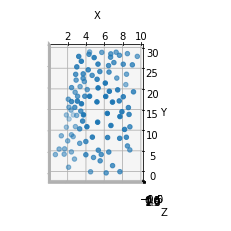

In [19]:
points = points_from_image()
plot_points(points)

In [20]:
import find_holds

In [21]:
class TestFindHolds(unittest.TestCase):

    def test_possible_configurations(self):
        climbing_face = [(0.0, 0.0, 0.0), (0.0, 1.0, 0.0), (1.0, 1.0, 0.0), (1.0, 0.0, 0.0), (2.0, 1.0, 0.0), (2.0, 2.0, 0.0)]
        initial_holds = [(0.0, 0.0, 0.0), (0.0, 1.0, 0.0), (1.0, 1.0, 0.0), (1.0, 0.0, 0.0)]
        goal_hold = (2.0, 2.0, 0.0)
        shortest_path = find_holds.get_possible_holds(climbing_face, initial_holds)
        expected = [((1.0, 1.0, 0.0), (2.0, 1.0, 0.0))]

        self.assertEqual(shortest_path, expected)

    def test_find_shortest_path(self):
        climbing_face = [(0.0, 0.0, 0.0), (0.0, 1.0, 0.0), (1.0, 1.0, 0.0), (1.0, 0.0, 0.0), (2.0, 1.0, 0.0), (2.0, 2.0, 0.0)]
        initial_holds = [(0.0, 0.0, 0.0), (0.0, 1.0, 0.0), (1.0, 1.0, 0.0), (1.0, 0.0, 0.0)]
        goal_hold = (2.0, 2.0, 0.0)
        shortest_path = find_holds.shortest_path(climbing_face, initial_holds=initial_holds, goal_hold=goal_hold)
        expected = [(1.0, 1.0, 0.0), (2.0, 1.0, 0.0), (2.0, 2.0, 0.0)]
        self.assertEqual(shortest_path, expected)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

FF..
FAIL: test_find_shortest_path (__main__.TestFindHolds)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-21-c7d7812408d7>", line 18, in test_find_shortest_path
    self.assertEqual(shortest_path, expected)
AssertionError: <networkx.classes.graph.Graph object at 0x7ff001265c18> != [(1.0, 1.0, 0.0), (2.0, 1.0, 0.0), (2.0, 2.0, 0.0)]

FAIL: test_possible_configurations (__main__.TestFindHolds)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-21-c7d7812408d7>", line 10, in test_possible_configurations
    self.assertEqual(shortest_path, expected)
AssertionError: Lists differ: [] != [((1.0, 1.0, 0.0), (2.0, 1.0, 0.0))]

Second list contains 1 additional elements.
First extra element 0:
((1.0, 1.0, 0.0), (2.0, 1.0, 0.0))

- []
+ [((1.0, 1.0, 0.0), (2.0, 1.0, 0.0))]

-----------------------------------------------------------------